In [1]:
import os
# os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc

import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time

/Users/davidamat/.pyenv/versions/3.8.6/envs/deepsetstats/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import math

In [3]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [4]:
utils_tools = reload(utils_tools)
c = reload(c)
vc = reload(vc)

In [5]:
# Constants



# 1. Load Videos and Dictionary of vids

In [6]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [7]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court Detection

In [8]:
# Input frame
tourn = "wb"
frame = d_f[tourn].copy()
vt = d_vc[tourn]

## 3.1 Court Type

In [9]:
%%time
# Court type
rgb_court, court_type = VC.detect_court(frame)
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: GRASS
Court RGB Colors: {'COURT': array([137, 133,  88]), 'LINE_CLEAN': array([244, 232, 226]), 'LINE_DIRTY': array([170, 168, 134])}
CPU times: user 3.07 ms, sys: 1.89 ms, total: 4.96 ms
Wall time: 2.92 ms


## 3.2 White Filtering

In [10]:
%%time
#mask_lines = VC.get_line_mask(frame, court_type)
#VC.show_gray(mask_lines)
# VC.show_gray(mask_lines[500:600,200:300])

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 10 µs


In [11]:
class GradientImage():
    def __init__(self, dx_pixels=6, dy_pixels=6):
        self.pixels_shift_up = dy_pixels
        self.pixels_shift_down = dy_pixels
        self.pixels_shift_left = dx_pixels
        self.pixels_shift_right = dx_pixels
    
    def get_grads(self, img):
        return self.shift_frame_up(img), self.shift_frame_down(img), self.shift_frame_left(img), self.shift_frame_right(img)
    
    def shift_frame_up(self, img):
        return np.array(
            np.vstack((
                img[self.pixels_shift_up:, :], 
                img[-self.pixels_shift_up:, :]
            )), 
            dtype=int)

    def shift_frame_down(self, img):
        return np.array(np.vstack((img[:self.pixels_shift_down, :], img[:-self.pixels_shift_down, :])), dtype=int)

    def shift_frame_left(self, img):
        return np.array(np.hstack((img[:, self.pixels_shift_left:], img[:, -self.pixels_shift_left:])), dtype=int)

    def shift_frame_right(self, img):
        return np.array(np.hstack((img[:, :self.pixels_shift_right], img[:, :-self.pixels_shift_right])), dtype=int)
    
    def get_frame_diff(self, shift_fun, img):
        frame_diff = shift_fun(img) - img
        frame_diff[frame_diff < 0] = 0
        return np.mean(frame_diff, axis=2, dtype=int)
    
    def get_frame_directions_diff(self, img):
        #shifts_dirs = [self.shift_frame_up, self.shift_frame_down, self.shift_frame_left, self.shift_frame_right]
        #shifts_dirs = [self.shift_frame_up, self.shift_frame_left]
        return (self.get_frame_diff(self.shift_frame_up, img),
            self.get_frame_diff(self.shift_frame_down, img),
            self.get_frame_diff(self.shift_frame_left, img), 
            self.get_frame_diff(self.shift_frame_right, img))
    
    @staticmethod
    def multiply_diffs(img1, img2):
        return np.sqrt(np.abs(np.multiply(img1, img2)))
    
    @staticmethod
    def apply_threshold(lines, th=50):
        mask_lines_bin = lines.copy()
        mask_idx = mask_lines_bin < th
        mask_lines_bin[mask_idx] = 1
        mask_lines_bin[~mask_idx] = 0
        return mask_lines_bin

In [12]:
%%time
grad = GradientImage()
frame_up, frame_down, frame_left, frame_right = grad.get_grads(frame)

CPU times: user 24.5 ms, sys: 25.3 ms, total: 49.8 ms
Wall time: 46.7 ms


In [13]:
%%time
fdup, fddown, fddleft, fddright = grad.get_frame_directions_diff(frame)
mask_lines_bin = np.maximum(grad.shift_frame_down(fdup), grad.shift_frame_left(fddright))
mask_lines_bin2 = np.maximum(grad.shift_frame_up(fddown), grad.shift_frame_right(fddleft))
mask_both = grad.multiply_diffs(mask_lines_bin, mask_lines_bin2)

CPU times: user 155 ms, sys: 42.7 ms, total: 197 ms
Wall time: 197 ms


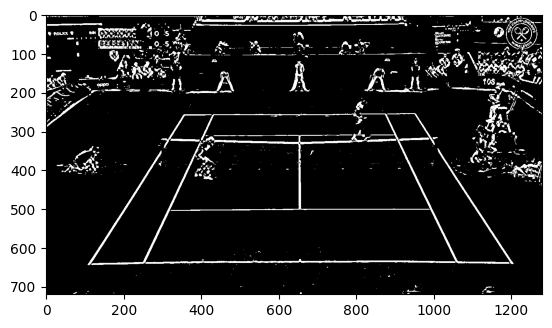

In [14]:
# rg: 15
# us/ao: 20
# wb: 30
mask_final = grad.apply_threshold(mask_both, th=30)
VC.show_gray(mask_final*255)

# Line Detection LSD

In [15]:
img_final = arr = np.uint8(mask_final * 255.)
blurred = cv2.GaussianBlur(img_final, (3,3), 0)
g_hpf = img_final # - blurred

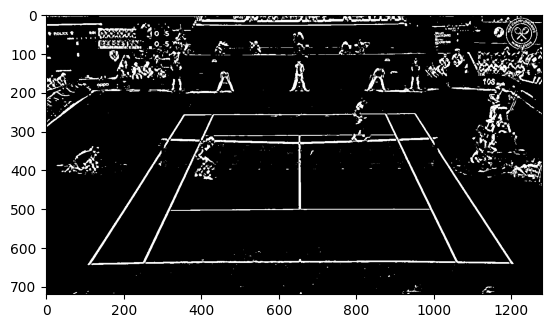

In [34]:
#VC.show_gray(g_hpf[400:500,600:700])
VC.show_gray(g_hpf)

In [17]:
%%time
#img_final = arr = np.uint8(mask_final * 255.)
#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(g_hpf)[0] #Position 0 of the returned tuple are the detected lines

CPU times: user 42 ms, sys: 9.72 ms, total: 51.8 ms
Wall time: 46 ms


In [18]:
%%time
dfl = pd.DataFrame(lines.squeeze(), columns=["x1","y1","x2","y2"])
dfl["line_length"] = np.sqrt((dfl["x1"]-dfl["x2"])**2 + (dfl["y1"]-dfl["y2"])**2)
dfl = dfl.sort_values("line_length", ascending=False)
# try: 30
dfl = dfl[dfl["line_length"] > 30]

CPU times: user 3.64 ms, sys: 1.81 ms, total: 5.45 ms
Wall time: 4.41 ms


In [19]:
lines_clean = dfl.drop("line_length", axis=1).values
lines_clean = lines_clean[:,None,:]

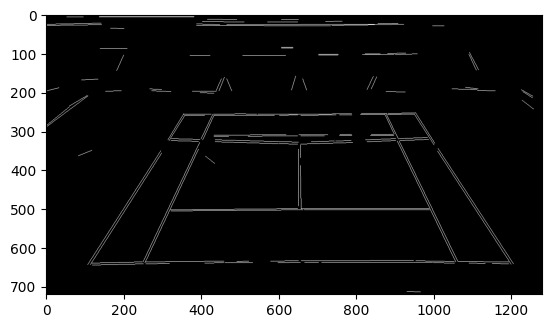

In [20]:
#Draw detected lines in the image
ones = np.uint8(np.ones_like(g_hpf) * 255.)
drawn_img = lsd.drawSegments(ones, lines_clean)
drawn_img = VC._correct_color(drawn_img, gray=True)

#Show image
VC.show_gray(drawn_img)

In [21]:
%%time
hough = cv2.HoughLinesP(np.uint8(drawn_img), 1, np.pi/180, 5, minLineLength=10, maxLineGap=250)

CPU times: user 468 ms, sys: 7.68 ms, total: 476 ms
Wall time: 475 ms


In [31]:
cv2.HoughLinesP?

Docstring:
HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]) -> lines
.   @brief Finds line segments in a binary image using the probabilistic Hough transform.
.   
.   The function implements the probabilistic Hough transform algorithm for line detection, described
.   in @cite Matas00
.   
.   See the line detection example below:
.   @include snippets/imgproc_HoughLinesP.cpp
.   This is a sample picture the function parameters have been tuned for:
.   
.   ![image](pics/building.jpg)
.   
.   And this is the output of the above program in case of the probabilistic Hough transform:
.   
.   ![image](pics/houghp.png)
.   
.   @param image 8-bit, single-channel binary source image. The image may be modified by the function.
.   @param lines Output vector of lines. Each line is represented by a 4-element vector
.   \f$(x_1, y_1, x_2, y_2)\f$ , where \f$(x_1,y_1)\f$ and \f$(x_2, y_2)\f$ are the ending points of each detected
.   line segment.
.   @param rh

In [22]:
hough.shape

(1303, 1, 4)

In [23]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

In [24]:
%%time
# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx, idx] = 255
image[line(45, 25, 25, 175)] = 255
image[line(25, 135, 175, 155)] = 255

CPU times: user 295 µs, sys: 491 µs, total: 786 µs
Wall time: 1.98 ms


In [25]:
%%time
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

CPU times: user 3.17 ms, sys: 1.83 ms, total: 5 ms
Wall time: 4.7 ms


In [38]:
%%time
h, theta, d = hough_line(drawn_img, theta=tested_angles)

CPU times: user 835 ms, sys: 8.52 ms, total: 843 ms
Wall time: 843 ms


In [45]:
%%time
lines = cv2.HoughLinesP(drawn_img, 1, np.pi / 180, 80, minLineLength=100, maxLineGap=20)

CPU times: user 508 ms, sys: 8.75 ms, total: 516 ms
Wall time: 518 ms


In [46]:
lines = np.squeeze(lines)

In [48]:
lines

array([[   0,  348, 1279,  528],
       [  39,    0,  758,  719],
       [   0,  474, 1279,  155],
       ...,
       [   0,  382, 1207,  169],
       [ 495,  658, 1279,  589],
       [ 600,  529, 1279,  372]], dtype=int32)

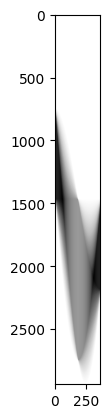

In [43]:
VC.show_gray(h)

In [40]:
h.shape

(2939, 360)

In [27]:
h.shape

(567, 360)

In [28]:
theta.shape

(360,)

In [30]:
d.shape

(567,)

In [ ]:
%%time
# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

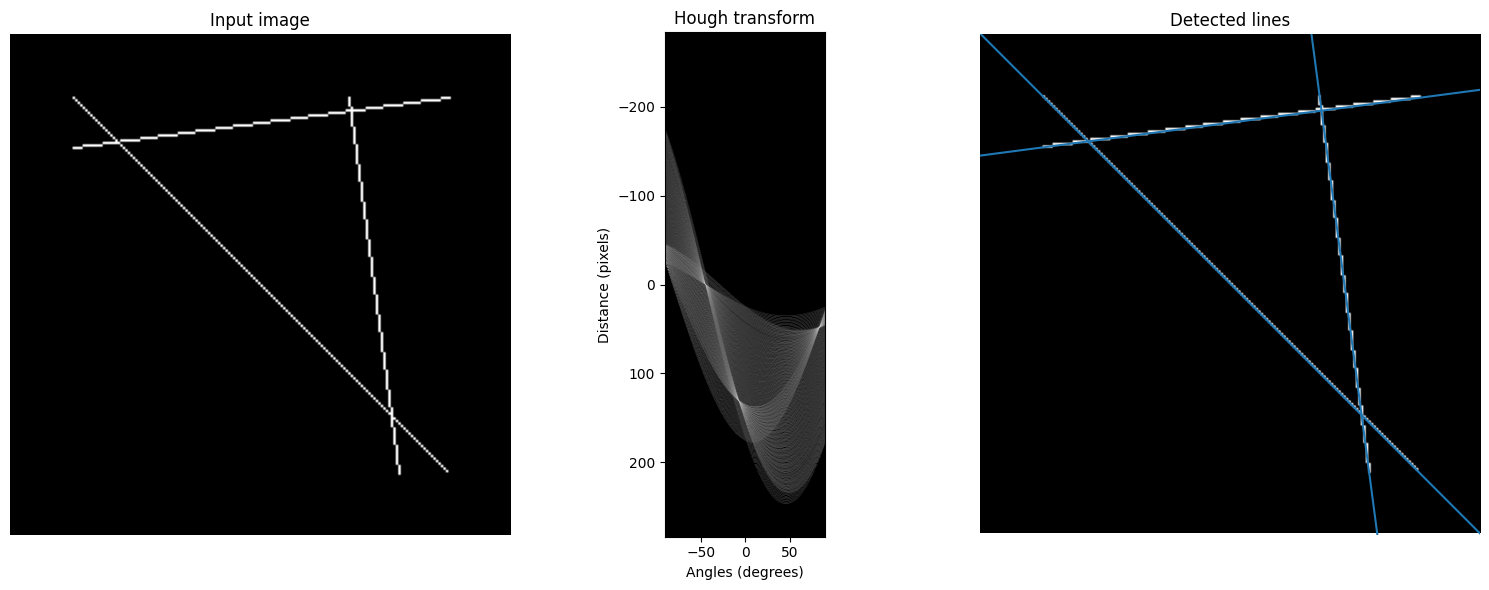

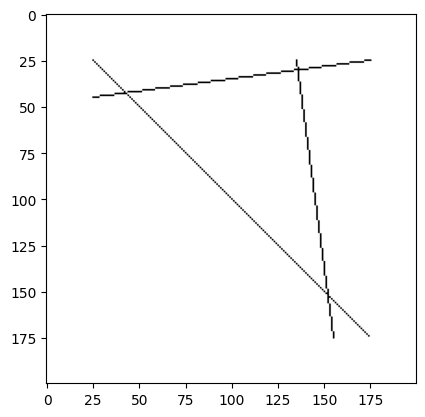

In [219]:
VC.show_gray(image)

In [ ]:
import cv2
import numpy as np

gray = np.uint8(image)
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

minLineLength = 550
maxLineGap = 70
lines = cv2.HoughLinesP(close,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(36,255,12),3)

cv2.imshow('thresh', thresh)
cv2.imshow('close', close)
cv2.imshow('image', image)
cv2.waitKey()

In [372]:
gray = np.uint8(mask_final*255)
framef = frame.copy()

In [368]:
%%time
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(mask_both,50,150,apertureSize = 3)

CPU times: user 10 ms, sys: 10.1 ms, total: 20.2 ms
Wall time: 9.74 ms


In [398]:
# https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

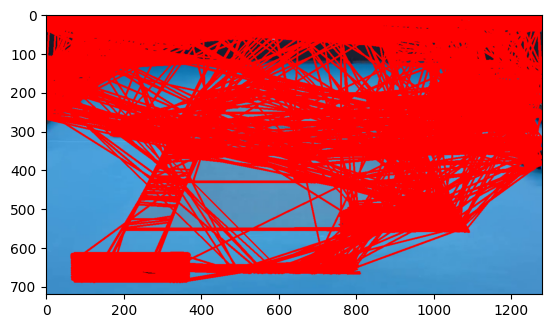

In [397]:
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_both), 50, 150)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 5, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_frame(framef)

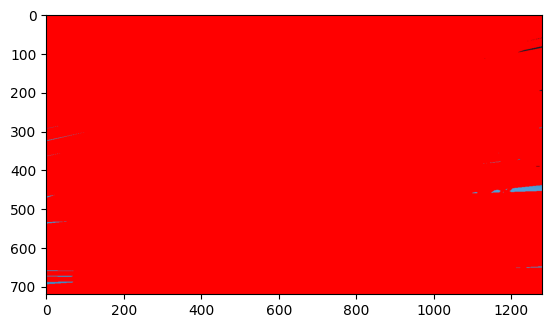

In [387]:
VC.show_frame(framef)

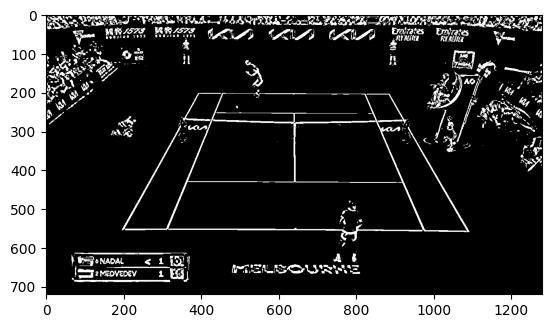

### Correct Slice

In [126]:
slif = frame[285:300, 505:506]
slim = mask_lines_bin[200:245, 400:655]

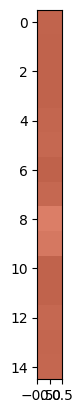

In [127]:
VC.show_frame(slif)

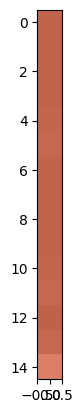

In [139]:
VC.show_frame(frame_down)

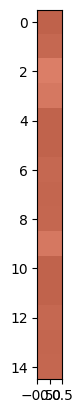

In [130]:
VC.show_frame(frame_up)

In [129]:
grad = GradientImage(slif)
frame_up, frame_down, frame_left, frame_right = grad.get_grads()

In [131]:
diff_up = slif - frame_up

In [138]:
diff_up

array([[[  2,   2,   2]],

       [[ -5,  -5,  -5]],

       [[-27, -27, -27]],

       [[-21, -21, -21]],

       [[  3,   3,   3]],

       [[  5,   5,   5]],

       [[ -6,  -6,  -6]],

       [[  2,   2,   2]],

       [[ 23,  23,  23]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]]])

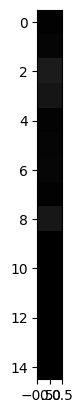

In [136]:
VC.show_frame(np.abs(diff_up))

In [307]:
sli.min(axis=1)

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
         0.,   0.,   0., 255., 255., 255., 255., 255., 255.])

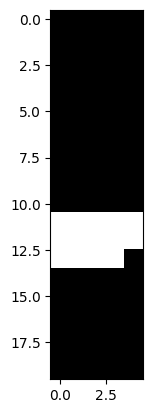

In [308]:
VC.show_gray(sli)

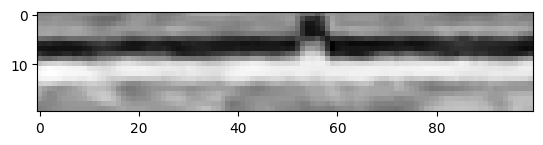

In [184]:
VC.show_gray(frame_diff_down[625:645, 600:700])

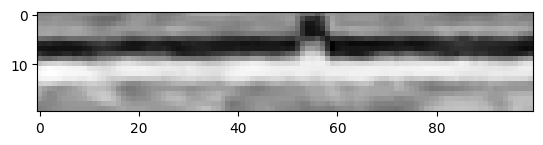

In [185]:
VC.show_gray(frame_diff_up[625:645, 600:700])

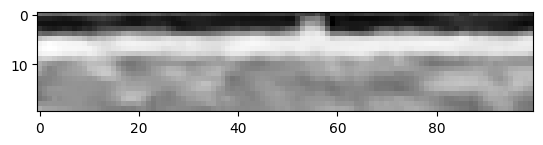

In [175]:
VC.show_gray(frame_diff_up_to_down[625:645, 600:700])

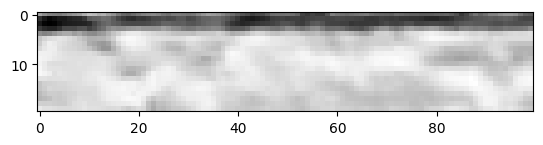

In [176]:
VC.show_gray(frame_diff_down_to_up[625:645, 600:700])

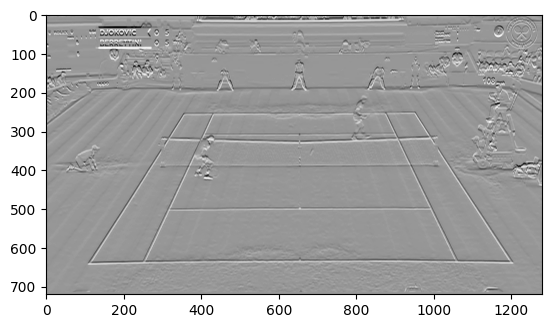

In [143]:
VC.show_gray(frame_diff_up)

In [106]:
np.max(frame_diff)

255.0

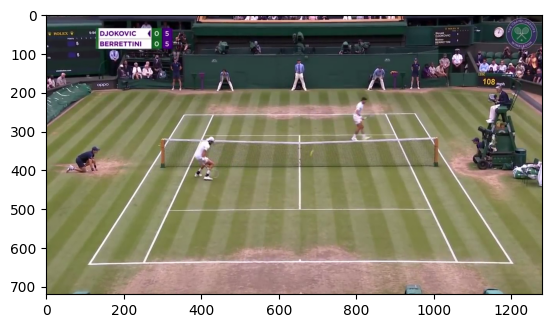

In [116]:
VC.show_frame(frame_down)